<a href="https://colab.research.google.com/github/MrLeo22/ML_course_Pavia_23/blob/main/2D_Unet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***AIM***
To train a neural network model for water-T2 (wT2) pixel-wise prediction of the lower limbs for a cohort of neuromuscular disorders. It is an image-to-image translation problem in supervised regression mode.

# ***BACKGROUND***
In this notebook, we will train a 2D-Unet to predict the pixel-wise wT2 value (measured in millisecond, ms) of lower limbs from MRI images. wT2 is a validated MRI biomarker that correlates with the amount of inflammation that muscles undergo in several neuromuscular diseases. Standard analytical method to measure wT2 takes several time , up to 10 minutes per each patient. In clinical practice, it is desiderable to speed up the process of quantification, so Neural Network models break in.

For more info about the standard post-processing software: https://github.com/fsantini/MyoQMRI


***The input images*** of the network are ***Multi-echo Spin-Echo (17 echoes)*** images with 4-dimensions:  (slice, x, y, number of echo).

***The reference images*** are the ***water T2 maps*** computed with the standard post-processing software with 3-dimensions: (slice, x, y)



In [ ]:
''' mount google drive where dataset is stored '''
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
''' download dataset '''
!unzip /content/drive/MyDrive/MEET_repository/data/input.zip
!unzip /content/drive/MyDrive/MEET_repository/data/reference.zip

In [ ]:
''' import all packages that we will need '''
import os
import numpy as np
# natsort package allow to load the input and reference data in numerical order, i.e. avoid any shuffling
import natsort as nt
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [ ]:
''' Set path to training set and test set for input and reference data '''
input_files = os.listdir('input')
reference_files = os.listdir('reference')
print(input_files)
print(reference_files)

In [ ]:
'''Create the paths to all npy files for input and reference training set'''
input_train = [os.path.join('input', input_files[0], x) for x in nt.natsorted(os.listdir('input/'+input_files[0]))]
reference_train = [os.path.join('reference', reference_files[0], x) for x in nt.natsorted(os.listdir('reference/'+reference_files[0]))]

print(input_train)
print(reference_train)

'''Create the paths to all npy files for input and reference test set'''
input_test = [os.path.join('input', input_files[1], x) for x in nt.natsorted(os.listdir('input/'+input_files[1]))]
reference_test =  [os.path.join('reference', reference_files[1], x) for x in nt.natsorted(os.listdir('reference/'+reference_files[1]))]

print(input_test)
print(reference_test)


In [ ]:
'''select 100 train input and reference data to avoid RAM issue in model.fit'''
input_train = input_train[:100]
reference_train = reference_train[:100]


In [ ]:
'''load data with numpy package'''
def load_data(x,y):
  inp = np.array([np.load(ima) for ima in x])
  ref = [np.load(ima) for ima in y]
  ref = np.array([ima[0,:,:] if ima.shape[0] == 2 else ima for ima in ref])
  return inp, ref

train_input_arr, train_reference_arr = load_data(input_train, reference_train)
test_input_arr, test_reference_arr = load_data(input_test, reference_test)

print("input trainset shape: {i}, reference trainset shape: {j}".format(i=train_input_arr.shape, j=train_reference_arr.shape))
print("input testset shape: {i}, reference testset shape: {j}".format(i=test_input_arr.shape, j=test_reference_arr.shape))

In [ ]:
''' let's plot some couple of input and reference training data '''
for i in range(0,3):
  # np.rot90 to rotate the x-y plane for better visualization
  plt.imshow(np.rot90(train_input_arr[i,:,:,1],1), cmap = 'gray')
  plt.figure()
  plt.imshow(np.rot90(train_reference_arr[i,:,:],1), cmap='gray')
  plt.figure()


In [ ]:
'''Input and reference normalization'''
# MinMaxScaler for input data between [0,1]
def getminmax(x):
  data = x.flatten()
  val_max = np.max(data)
  val_min = np.min(data)
  return val_max, val_min

def minmaxscaler(x,inf,sup):
  scaled = [(ima - val_min)/(val_max-val_min) for ima in x]
  scaled_arr = np.array(scaled)
  return scaled_arr

# concatenate train and test input arr to get min and max values for the entire datastack
data = np.concatenate((train_input_arr, test_input_arr), axis = 0)
val_max, val_min = getminmax(data)

train_input_arr_scaled = minmaxscaler(train_input_arr, val_min, val_max)
test_input_arr_scaled = minmaxscaler(test_input_arr, val_min, val_max)

# The values range for reference_arr is [0,100 ms] because wT2 in neuromuscular disordes naturally ranges in this inteval. So, wT2 values are rescaled in [0,1] with simple *0.01 multiplication
train_reference_arr_scaled = train_reference_arr*0.01
test_reference_arr_scaled = test_reference_arr*0.01

print("input scaled min value: {i}, max value: {j}".format(i=np.min(train_input_arr_scaled), j=np.max(train_input_arr_scaled)))
print("reference scaled min value: {i}, max value: {j}".format(i=np.min(train_reference_arr_scaled), j=np.max(train_reference_arr_scaled)))


In [ ]:
''' let's plot some couple of rescaled input and reference training data '''
for i in range(0,3):
  plt.imshow(np.rot90(train_input_arr_scaled[i,:,:,0],1), cmap = 'gray')
  plt.figure()
  plt.imshow(np.rot90(train_reference_arr_scaled[i,:,:],1), cmap='gray')
  plt.figure()

# ***Let's dive into the network***

***U-net*** consists in sequantial blocks (blue boxes) where the inputs (images) are mathematically transformed to learn high-level features, i.e. deeper representation of the inputs. Figure below: pictorial description of ***U-net*** architecture.

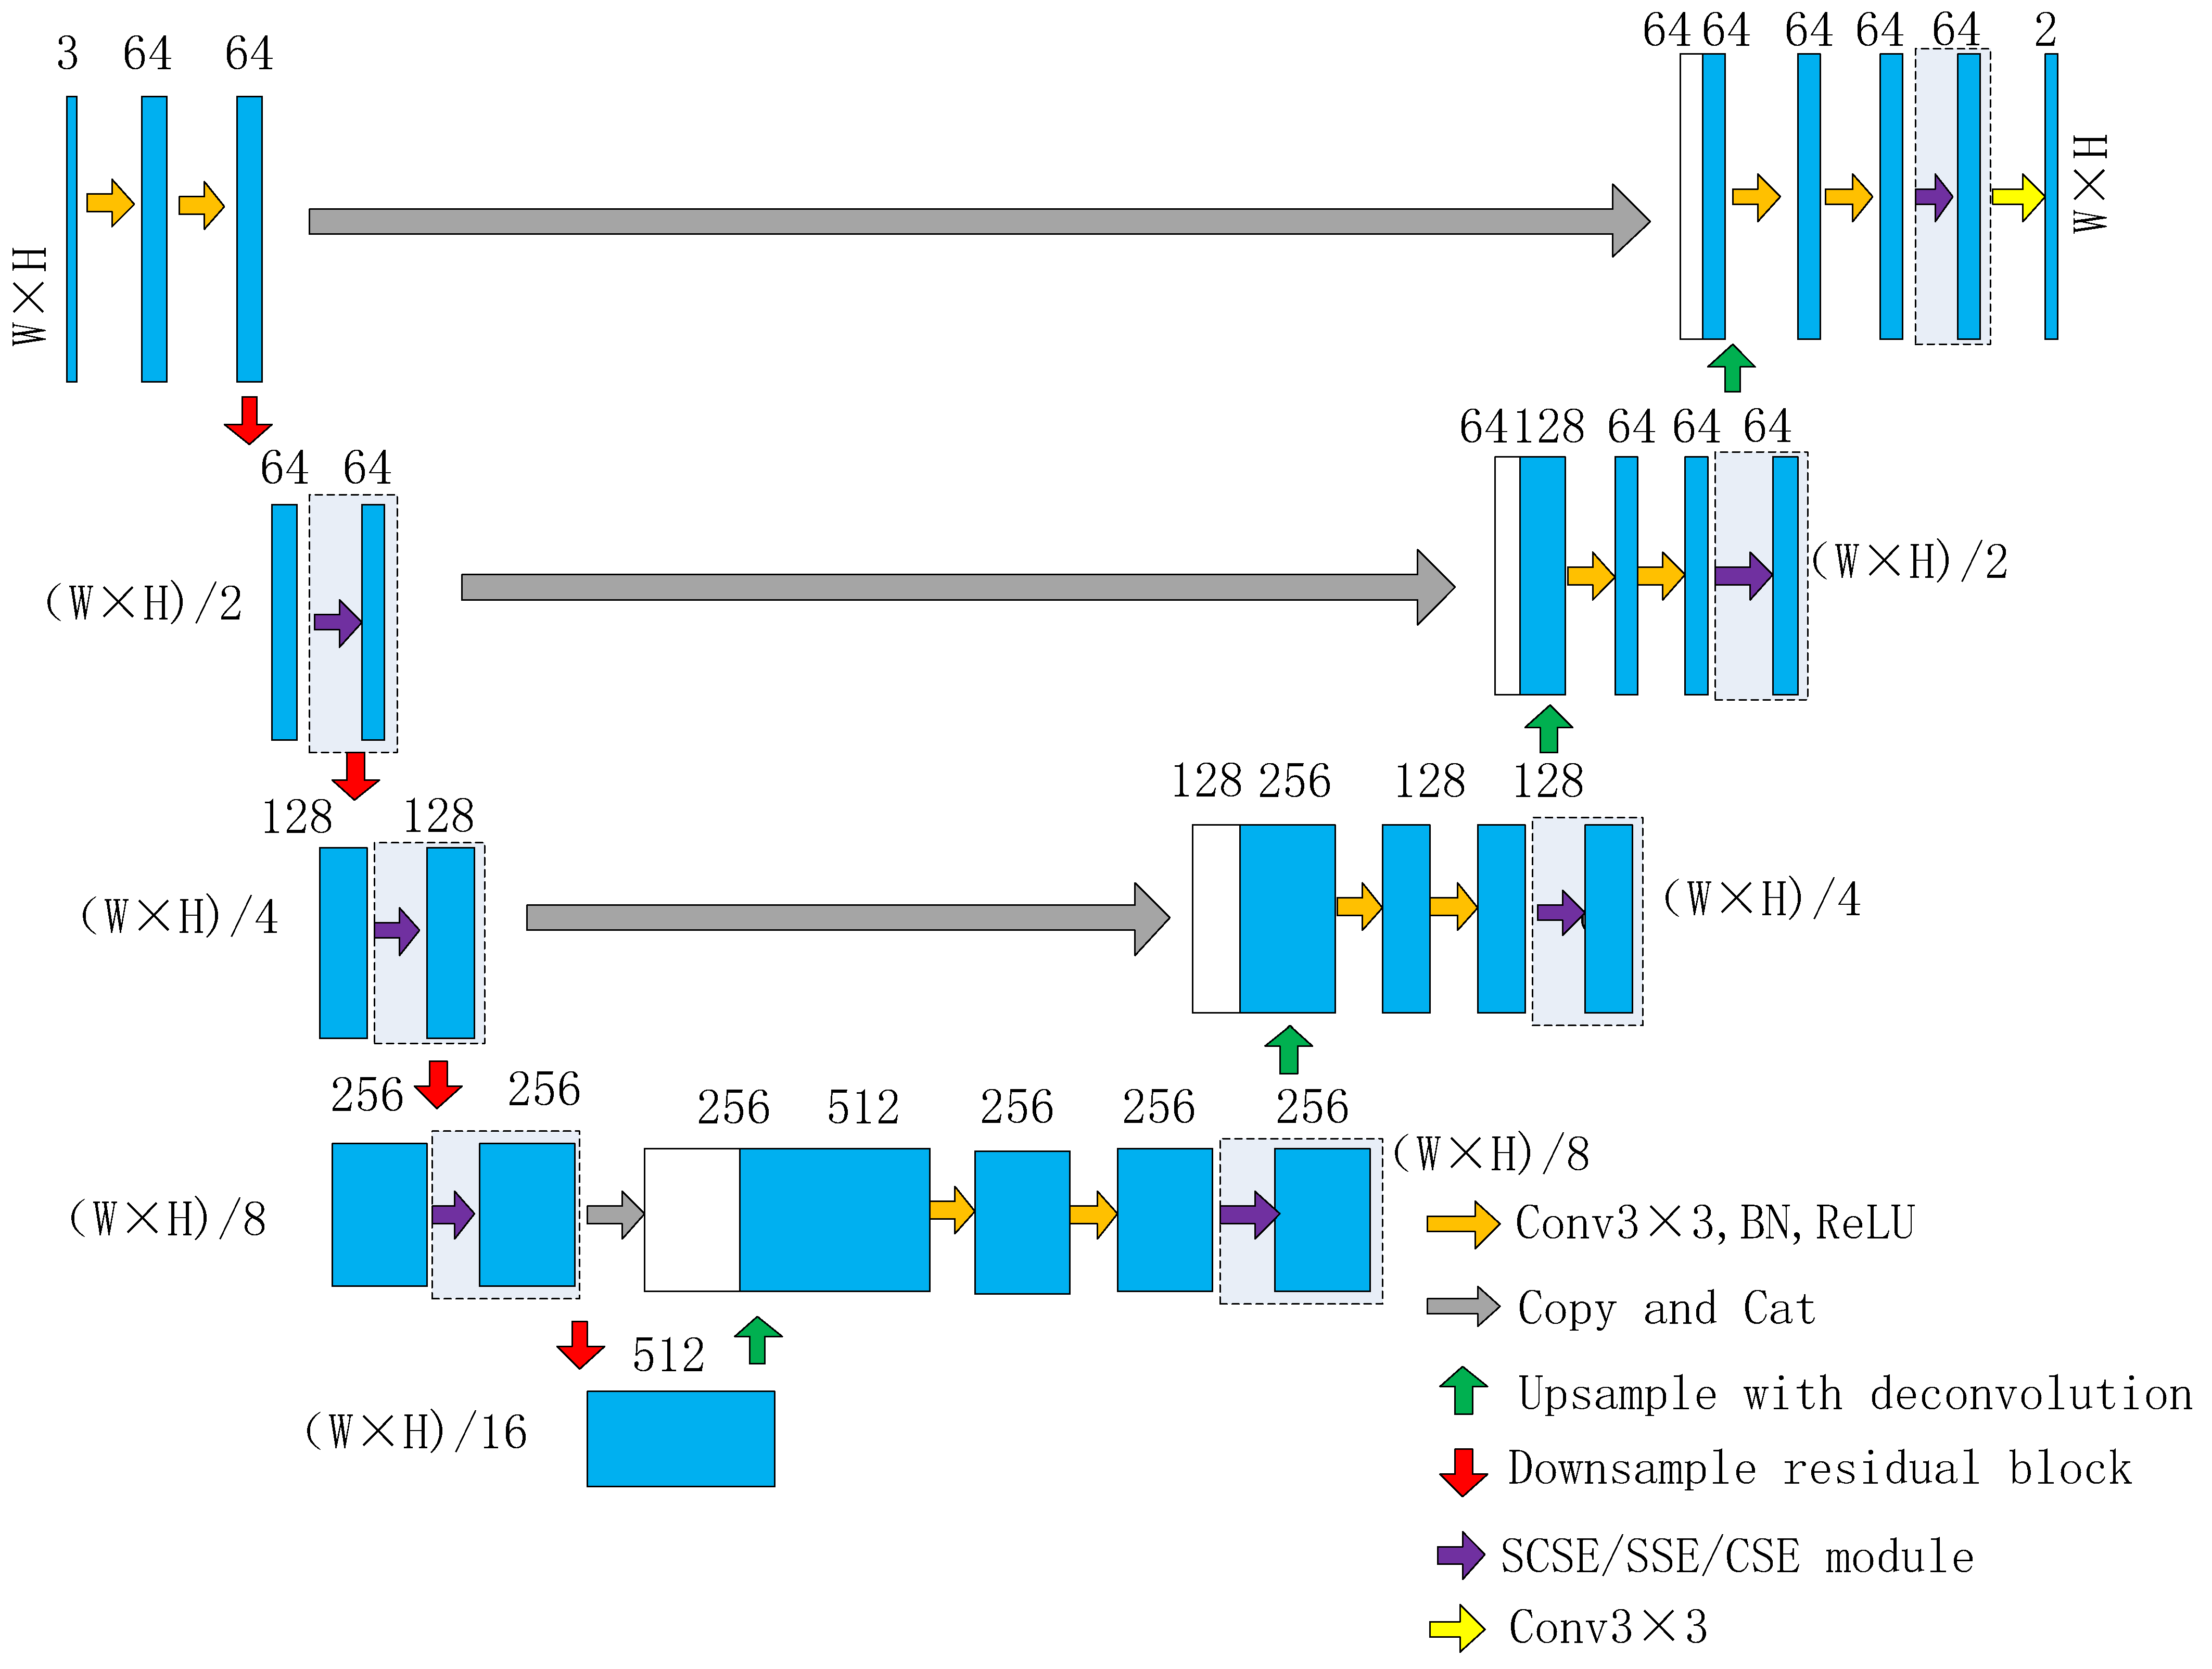

# ***MODEL DEFINITION***

***2D- Unet*** model definition with ***Keras API***.

***BASIC UNITS***
- ***Encoder block*** :

**i)** ***Conv2D*** with k filters (3,3);

**ii)** two ***Residual Block*** to promote identity mapping. Each residual is composed by ***BatchNorm, ReLu activation, Conv2D***. The ***Addition*** layer between the input and output of residual layer is the exit of ***Residual Block***

**iii)** ***Conv2D*** with k filters (3,3) with stride (2,2) to halve the matrix size

- ***Bottleneck block***:

connect the encoder to the decoder branch with ***Conv2D, Residual Block*** without changes to the matrix size

- ***Decoder block***:

**i)** ***Conv2DTranspose*** with k filters (3,3);

**ii)** ***Concatenate*** layer for skip connection with the encoder block

**iii)** ***Conv2D*** with k filters (3,3) to extract features from the concatenate layer

**iv)** two ***Residual Block*** to promote identity mapping. Each residual is composed by ***BatchNorm, ReLu activation, Conv2D***. The ***Addition*** layer between the input and output of residual layer is the exit of ***Residual Block***

**v)** ***Conv2DTranspose*** with k filters (3,3) with stride (2,2) to double the matrix size

***NETWORK ARCHITECTURE***

Encoder branch with four  ***Encoder block***: each block has double number of filters with respect to the previous block.

Bottleneck to connect the encoder to decoder branch.

Decoder branch with four ***Decoder block***: each block has half the number of filter of the previous block to restore the original matrix size.


Exit of the model is a ***Conv2D*** layer + ***ReLu activation*** to match the expected number of channel, i.e. 1


In [ ]:
X_train, y_train = train_input_arr_scaled, train_reference_arr_scaled

In [ ]:
keras.backend.clear_session()

def BatchActivate(x):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = keras.layers.Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation==True: x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters, batch_activate=False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3))
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = keras.layers.Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

# encoder block
def encoder(previous_layer,k, **kargs):
    d = keras.layers.Conv2D(k,3,padding="same",**kargs)(previous_layer)
    res = residual_block(d,k)
    res = residual_block(res,k, True)
    d = keras.layers.Conv2D(k,3,strides=(2,2),padding='same', **kargs)(res)
    d = BatchActivate(d)
    return d

# bottleneck block
def bottleneck(previous_layer,k, **kargs):
    b = keras.layers.Conv2D(k,3,padding="same",**kargs)(previous_layer)
    b = residual_block(b, k)
    b = residual_block(b, k, True)
    return b

# decoder block
def decoder(previous_layer,down_layer,k, **kargs):
    u = keras.layers.Conv2DTranspose(k,3,padding="same",**kargs)(previous_layer)
    u = keras.layers.Concatenate(axis=-1)([u,down_layer])
    u = BatchActivate(u)
    u = keras.layers.Conv2D(k,3,padding="same",**kargs)(u)
    res = residual_block(u,k)
    res = residual_block(res,k, True)
    u = keras.layers.Conv2DTranspose(k,3,strides=(2,2), padding="same", **kargs)(res)
    u = BatchActivate(u)
    return u

'''
params dictionary includes:
1) regularizer l2 to prevent overfitting
2) weights initializer set as random normal
'''
def model(input_shape=(384,192,17),k=16,reg=0.0001):
    inputs=keras.layers.Input(shape=(input_shape))

    params = {"kernel_regularizer" : keras.regularizers.l2(reg),
              "kernel_initializer" : 'random_normal'}

    d1 = encoder(inputs,k,**params)
    d2 = encoder(d1,k*2,**params)
    d3 = encoder(d2,k*4,**params)
    d4 = encoder(d3, k*8, **params)

    b = bottleneck(d4,k*16,**params)

    u1 = decoder(b,d4,k*8,**params)
    u2 = decoder(u1,d3,k*4,**params)
    u3 = decoder(u2,d2,k*2,**params)
    u4 = decoder(u3,d1,k,**params)

    out = keras.layers.Conv2D(1,1,padding="same",**params)(u4)
    out = keras.activations.relu(out)

    model=keras.models.Model(inputs=inputs,outputs=out)

    return model

In [ ]:
# call the model and check the summary
model = model()
model.summary()

# Call the optimizer and compile the model, i.e. configure the model for training
***Adam Optimizer*** for gradient descend, the ***Mean Squared Error (MSE)*** as loss function and the ***Mean Absolute Error (MAE)*** as accuracy metric

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.0001,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-08,
      amsgrad=True)
model.compile(
      loss='mse',
      optimizer=adam,
      metrics=["mean_absolute_error"])

# Model Fitting

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size = 1,
    epochs=50)

# **let's have a look to the training loss**

In [ ]:
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('mse loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')

# **let's evaluate the model with test set data**

In [ ]:
X_test, y_test = test_input_arr_scaled, test_reference_arr_scaled

# expand last dim of y_test to match the prediction dataset shape: useful to evaluate the accuracy metric between the test set and the model prediction
y_test = np.expand_dims(y_test, axis =-1)
y_test.shape

In [ ]:
evaluation = model.evaluate(X_test,y_test,
        batch_size=1,
        verbose="auto",
        steps=10
    )

out = model.predict(X_test)
print(out.shape)

In [ ]:
'''Let's plot the prediction made on the test set'''
for i in range(0,5):
  plt.imshow(out[i,...], cmap = 'gray')
  plt.figure()

# **Percentage relative error (PRE) metric and Structural Similarity index (SSIM) to assess test performance**

In [ ]:
# compute ssim slice-wise
ssim = tf.image.ssim(y_test.astype('float32'), out.astype('float32'), max_val=1.0)

# compute mean ssim over the prediction dataset
mean_ssim = tf.reduce_mean(ssim)
print('mean ssim index over the prediction dataset: {idx}'.format(idx=mean_ssim))

# compute the PRE maps between test and prediction set
pre = 100*(np.absolute((y_test - out)/y_test))


In [ ]:
'''Plot some pre maps'''
for fig in pre[:5,...]:
  plt.imshow(fig, cmap='gray')
  plt.figure()